In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# JAX
import jax
from jax import nn
import jax.numpy as jnp

from tensorflow import keras
# # "Fixar" números aleatórios a serem gerados
np.random.seed(0)

In [ ]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.reshape(-1, 32, 28*28).astype("float32") / 255
x_test = x_test.reshape(-1, 16, 28*28).astype("float32") / 255

# convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes).reshape(-1, 32, 10)
y_test = keras.utils.to_categorical(y_test, num_classes).reshape(-1, 16, 10)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def define_params(sizes=[1, 1]):
    weights = []
    for (in_dim, out_dim) in zip(sizes[:-1], sizes[1:]):
        weights.append({"w": np.random.randn(in_dim, out_dim) * np.sqrt(2/in_dim), 
                        "b": np.zeros(out_dim)})           
    
    return weights


def apply_fn(weights, batch_x, activations):
    output = batch_x
    for layer, act_fn in zip(weights, activations):
        output = jnp.dot(output, layer["w"]) + layer["b"]
        output = act_fn(output)
    return output

def cross_entropy(weights, batch_x, real_y, activations):
    pred_y = apply_fn(weights, batch_x, activations)
    real_y = jnp.asarray(real_y)
    return -jnp.mean(jnp.sum(pred_y * real_y, axis=1))

In [ ]:
def _accuracy(pred_y, real_y):
    p = np.argmax(pred_y, axis=1)
    real_y = np.argmax(real_y, axis=1)
    return np.sum(p == real_y) / len(pred_y)

@jax.jit
def evaluate(weights, batch_x, batch_y):
    # run feed forward network
    pred_y = apply_fn(weights, batch_x, activations)
    # loss
    loss = cross_entropy(weights, batch_x, batch_y, activations)
    return loss, _accuracy(pred_y, batch_y)

In [ ]:
@jax.jit
def train_step(weights, batch_x, batch_y, lr=0.03):
    loss, grads = jax.value_and_grad(cross_entropy)(weights, batch_x, batch_y, activations)
    weights = jax.tree_util.tree_multimap(lambda v, g: v - lr*g, weights, grads)
    return weights, loss

In [ ]:
nn = define_params(sizes=[28*28, 1024, num_classes])
activations=[jax.nn.relu, jax.nn.softmax]
train_losses = []
eval_losses = []
metrics = []

In [ ]:
for i in range(10):
  avg_loss = 0
  for (batch_x, batch_y) in zip(x_train, y_train):
    nn, loss = train_step(nn, batch_x, batch_y)
    avg_loss += loss
  train_losses.append(avg_loss/len(x_train))

  avg_acc = 0
  avg_loss = 0
  for (batch_x, batch_y) in zip(x_test, y_test):
    loss, acc = evaluate(nn, batch_x, batch_y)
    avg_acc += acc
    avg_loss += loss
  eval_losses.append(loss/len(x_test))
  metrics.append(avg_acc/len(x_test))

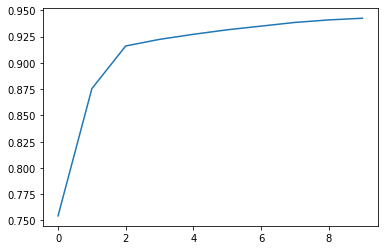

In [ ]:
plt.plot(range(len(metrics)), metrics)

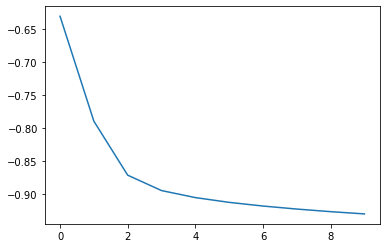

In [ ]:
plt.plot(range(len(train_losses)), train_losses)

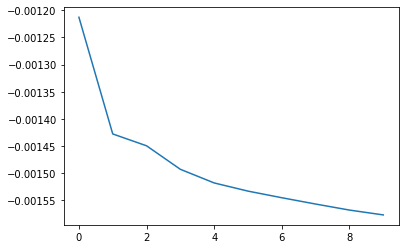

In [ ]:
plt.plot(range(len(eval_losses)), eval_losses)